In [11]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
from pathlib import Path
import json
import time
from copy import copy
from dataclasses import dataclass
from typing import List
from abc import ABC, abstractmethod

import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

from yolov7_detect import Yolov7Detector

from keypoint_detection.utils.load_checkpoints import get_model_from_wandb_checkpoint
from keypoint_detection.utils.heatmap import (
    get_keypoints_from_heatmap,
)
import torch
from torchvision.io import read_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T

import cone_detector.utils as cd_utils
import cone_detector.metrics as cd_metrics

np.set_printoptions(precision=3)


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Load data

In [2]:
dataset_path = Path("../test_set_real/dataset.json")

W, H = 1920, 1200
Sw, Sh = 9.21, 5.76
focal_length = 8

m = np.load("../keypoint-detection/model_evaluation/camera_calibration_baumer.npz")
camera_matrix = m["camera_matrix"]
distortion_matrix = m["distortion_matrix"]

IMAGE_SIZE = (128, 96)  # HxW

# Open the dataset and map image ids to their annotations
with open(dataset_path, "r") as f:
    dataset = json.load(f)

ann_by_image_id = {}

for annot in dataset["annotations"]:
    if annot["image_id"] not in ann_by_image_id:
        ann_by_image_id[annot["image_id"]] = [annot]
    else:
        ann_by_image_id[annot["image_id"]].append(annot)


def height_to_pos(heights, bottoms, category: int):
    """Converts an array of bottom px coordinates and cone heights to 3D positions

    Args:
        heights: array of N cone heights in px
        bottoms: array of Nx2 px locations (left bottom)
        category: the cone type

    Returns:
        Nx3 array of cone locations
    """
    CONE_HEIGHT = 0.5 if category == 2 else 0.305
    CONE_RING_HEIGHT = 0.032 if category == 2 else 0.0275
    CONE_RING_RADIUS = 0.196 / 2 if category == 2 else 0.153 / 2

    Z = (CONE_HEIGHT - CONE_RING_HEIGHT) * focal_length / (Sh * heights / H)

    return torch.vstack(
        [
            Z,
            -Z * (bottoms[:, 0] - camera_matrix[0, 2]) / camera_matrix[0, 0]
            - CONE_RING_RADIUS,
            -Z * (bottoms[:, 1] - camera_matrix[1, 2]) / camera_matrix[1, 1]
            - CONE_RING_HEIGHT,
        ]
    ).T


def extract_positions(annotations: List[dict], min_cone_height):
    """Extracts a Nx4 array of ground truth categories and positions from a list of annotations"""

    result = np.zeros((0, 4))

    for ann in annotations:
        entry = np.zeros(4)
        entry[0] = ann["category_id"] - 1  # blue cone is ID 0

        # Check whether this cone has GT information
        if "position" not in ann:
            continue

        # Check whether this cone is tall enough
        if ann["keypoints"][4] - ann["keypoints"][1] < min_cone_height:
            continue

        entry[1:] = ann["position"]

        result = np.vstack((result, entry))

    return result

# Load the models

In [3]:
kp_model = get_model_from_wandb_checkpoint(
    "luvdijck/thesis-monocular-depth-estimation/model-3pj640o9:v21"
)

weights = Path("runs/train/yolov74/weights/best.pt")
detector = Yolov7Detector(weights)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


Fusing layers... 
IDetect.fuse


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Predict the data

  0%|          | 0/22 [00:00<?, ?it/s]

1 blue_cone, 1 orange_cone_big, Done. (31.4ms) Inference, (1.7ms) NMS


  5%|▍         | 1/22 [00:00<00:13,  1.52it/s]

13 blue_cones, 11 yellow_cones, 4 orange_cone_bigs, 6 orange_cone_smalls, Done. (29.0ms) Inference, (1.5ms) NMS


  9%|▉         | 2/22 [00:03<00:42,  2.12s/it]

5 blue_cones, 3 yellow_cones, 2 orange_cone_bigs, Done. (37.4ms) Inference, (1.5ms) NMS


 14%|█▎        | 3/22 [00:05<00:35,  1.84s/it]

5 blue_cones, 3 yellow_cones, Done. (45.7ms) Inference, (2.0ms) NMS


 18%|█▊        | 4/22 [00:06<00:27,  1.50s/it]

2 blue_cones, Done. (30.8ms) Inference, (3.3ms) NMS


 23%|██▎       | 5/22 [00:07<00:20,  1.23s/it]

9 blue_cones, 5 yellow_cones, 1 orange_cone_small, Done. (53.4ms) Inference, (1.7ms) NMS


 27%|██▋       | 6/22 [00:09<00:23,  1.50s/it]

13 blue_cones, 9 yellow_cones, 4 orange_cone_bigs, 5 orange_cone_smalls, Done. (38.4ms) Inference, (2.2ms) NMS


 32%|███▏      | 7/22 [00:11<00:28,  1.93s/it]

6 blue_cones, 4 yellow_cones, 1 orange_cone_big, 2 orange_cone_smalls, Done. (52.9ms) Inference, (3.9ms) NMS


 36%|███▋      | 8/22 [00:14<00:28,  2.04s/it]

1 blue_cone, 3 yellow_cones, Done. (45.3ms) Inference, (1.6ms) NMS


 45%|████▌     | 10/22 [00:15<00:15,  1.25s/it]

Done. (29.0ms) Inference, (0.4ms) NMS
7 blue_cones, 1 yellow_cone, 3 orange_cone_bigs, 5 orange_cone_smalls, Done. (58.8ms) Inference, (3.7ms) NMS


 50%|█████     | 11/22 [00:17<00:15,  1.43s/it]

1 blue_cone, 1 yellow_cone, 1 orange_cone_small, Done. (58.9ms) Inference, (1.6ms) NMS


 55%|█████▍    | 12/22 [00:17<00:12,  1.23s/it]

2 blue_cones, Done. (29.3ms) Inference, (1.8ms) NMS


 59%|█████▉    | 13/22 [00:18<00:09,  1.05s/it]

1 yellow_cone, 1 orange_cone_small, Done. (35.8ms) Inference, (2.4ms) NMS


 64%|██████▎   | 14/22 [00:19<00:07,  1.01it/s]

17 blue_cones, 22 yellow_cones, Done. (62.0ms) Inference, (2.0ms) NMS


 68%|██████▊   | 15/22 [00:22<00:11,  1.66s/it]

1 blue_cone, 3 yellow_cones, 1 orange_cone_big, Done. (34.7ms) Inference, (3.4ms) NMS


 73%|███████▎  | 16/22 [00:23<00:08,  1.45s/it]

2 blue_cones, 1 yellow_cone, 3 orange_cone_smalls, Done. (48.0ms) Inference, (2.9ms) NMS


 77%|███████▋  | 17/22 [00:24<00:06,  1.29s/it]

9 blue_cones, 7 yellow_cones, 2 orange_cone_bigs, 2 orange_cone_smalls, Done. (37.9ms) Inference, (4.3ms) NMS


 82%|████████▏ | 18/22 [00:26<00:06,  1.58s/it]

3 blue_cones, 4 yellow_cones, Done. (29.0ms) Inference, (1.6ms) NMS


 86%|████████▋ | 19/22 [00:27<00:04,  1.39s/it]

5 blue_cones, 2 yellow_cones, 2 orange_cone_bigs, 1 orange_cone_small, Done. (29.0ms) Inference, (1.5ms) NMS


 91%|█████████ | 20/22 [00:28<00:02,  1.34s/it]

2 blue_cones, Done. (29.0ms) Inference, (1.6ms) NMS


 95%|█████████▌| 21/22 [00:29<00:01,  1.12s/it]

3 yellow_cones, Done. (29.1ms) Inference, (1.5ms) NMS


/opt/conda/lib/python3.10/site-packages/cone_detector/utils.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


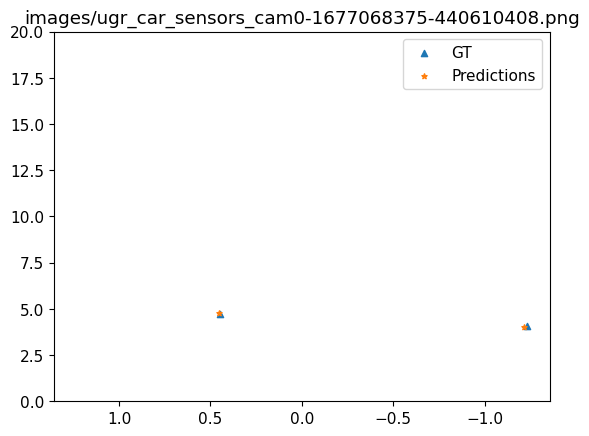

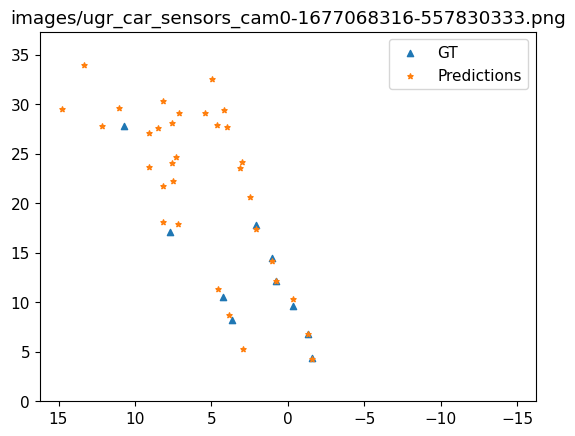

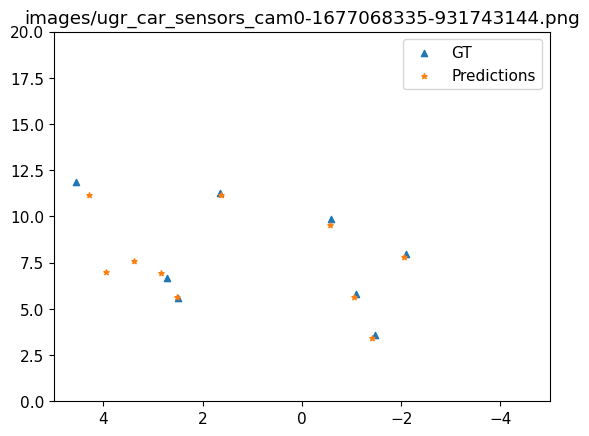

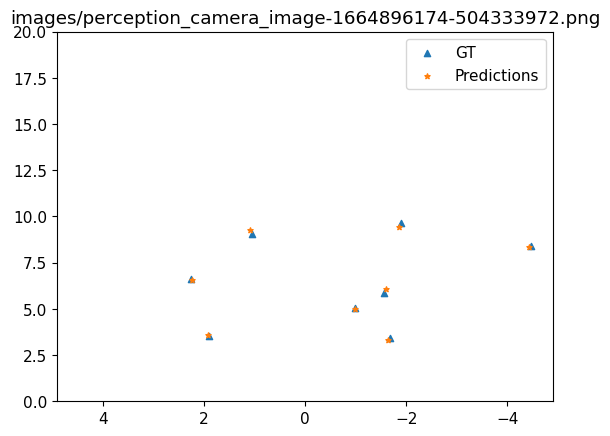

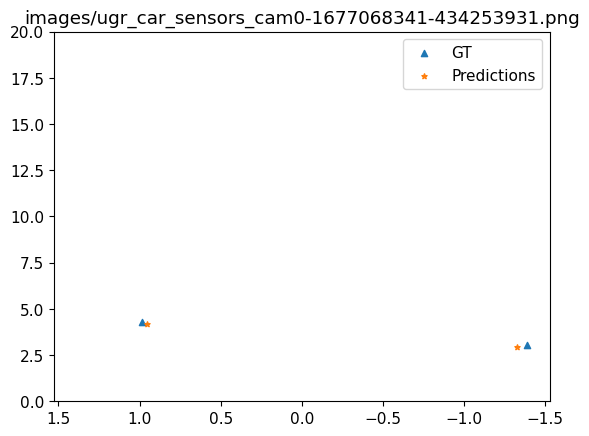

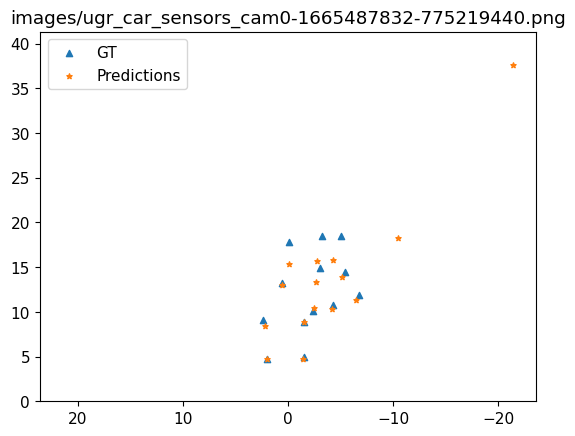

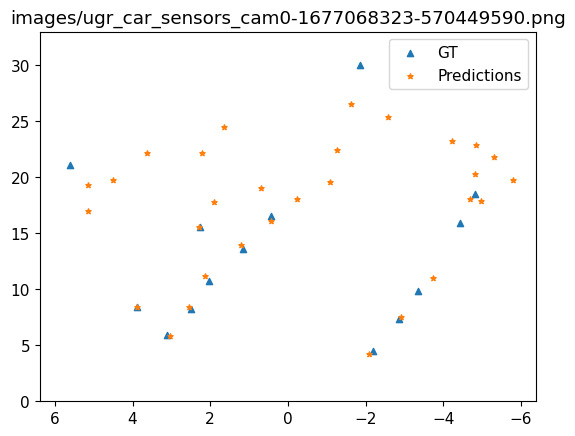

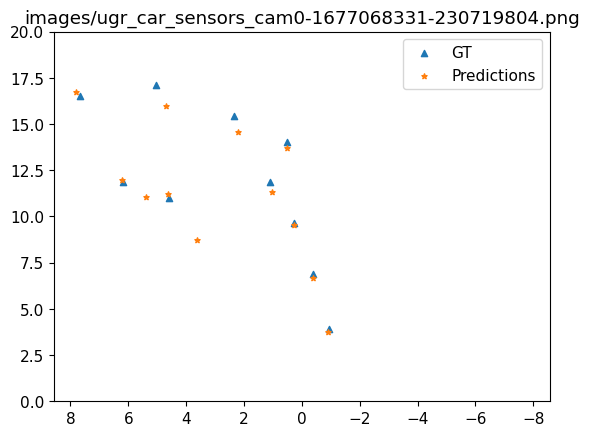

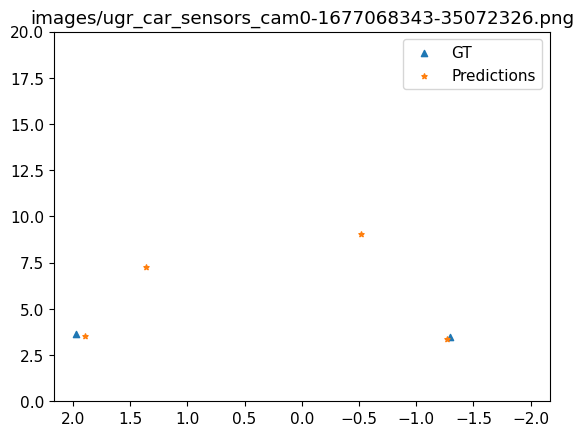

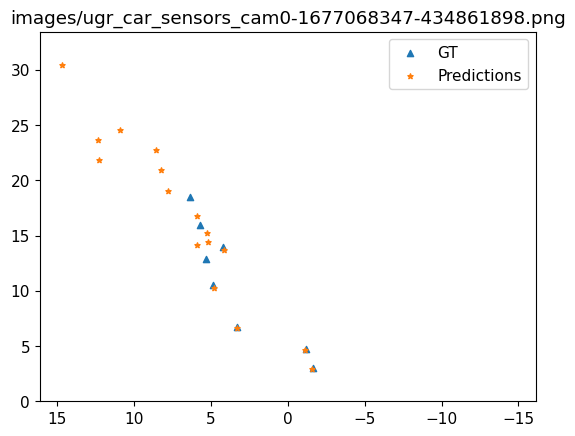

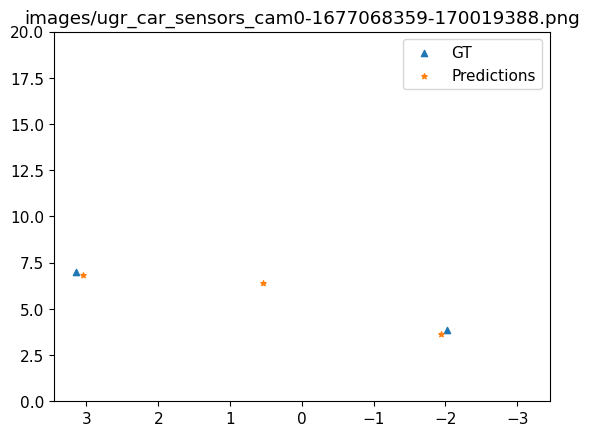

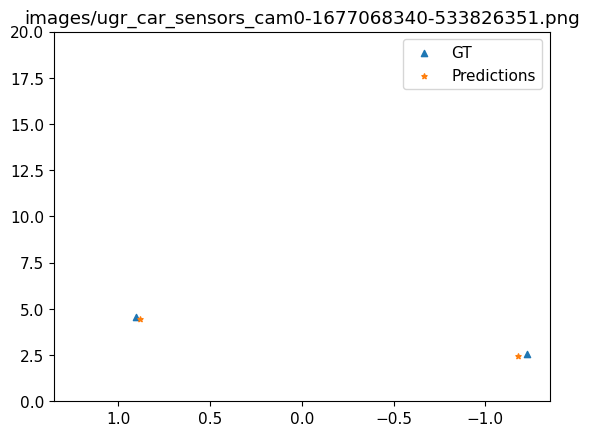

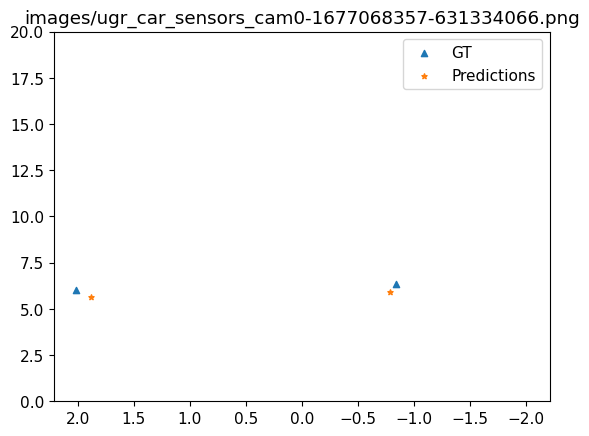

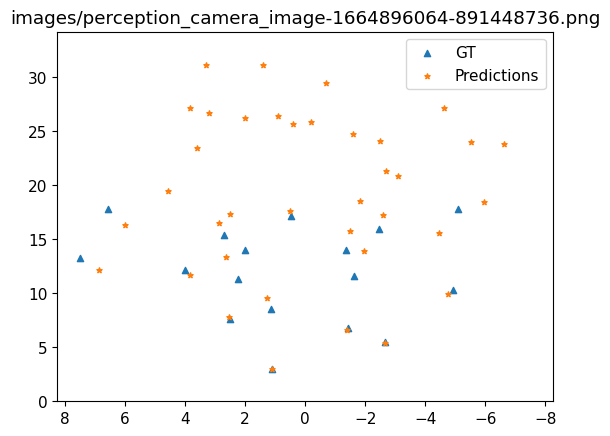

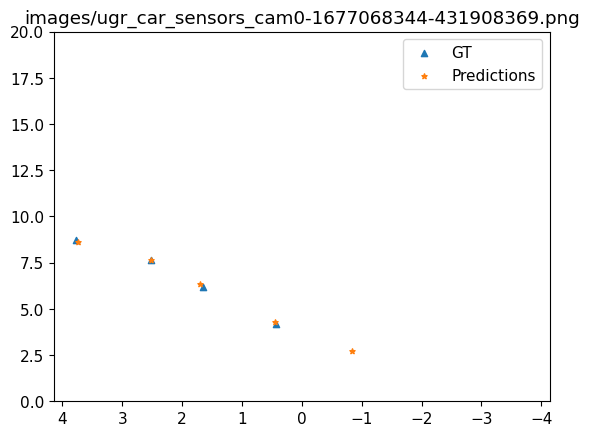

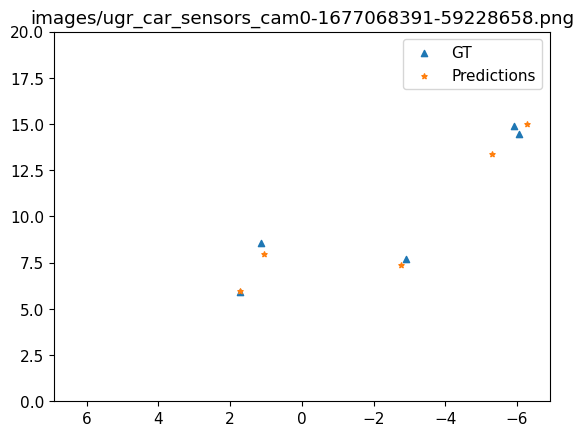

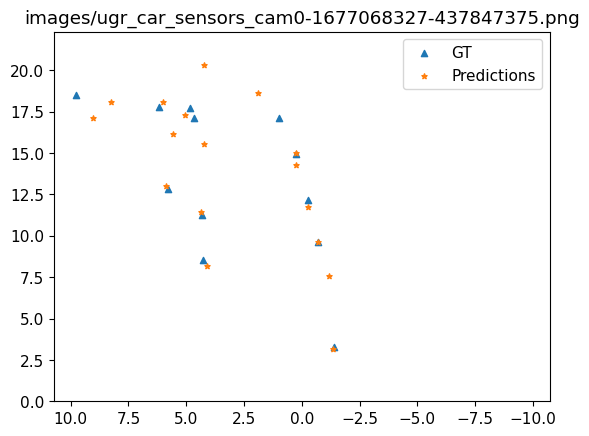

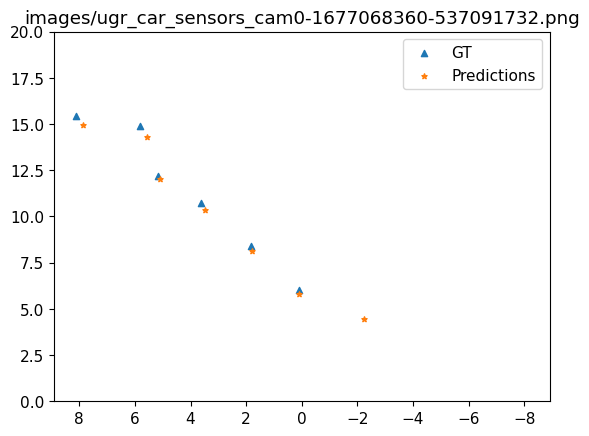

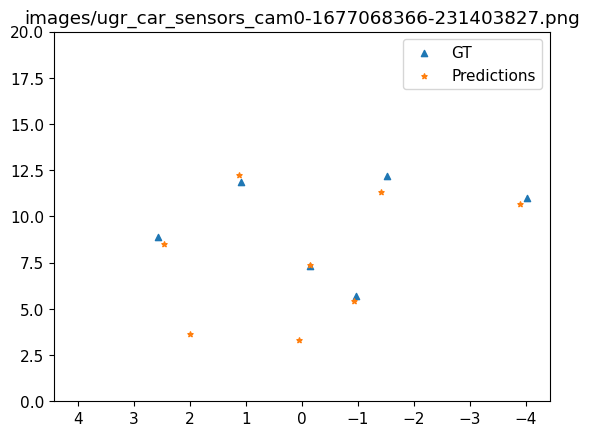

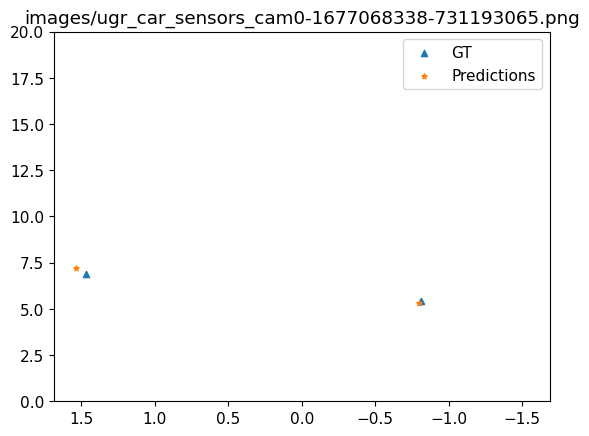

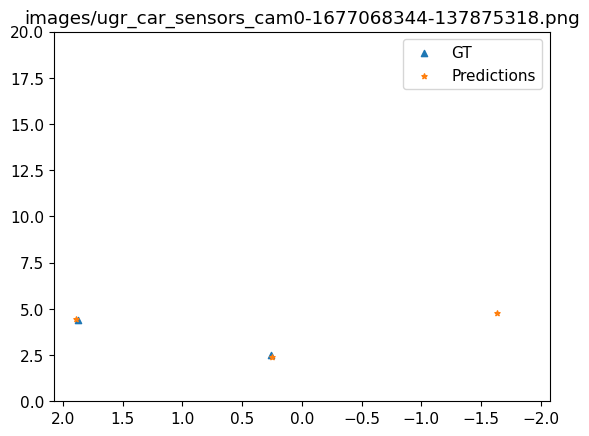

In [14]:
MIN_CONE_HEIGHT = 25
CONE_IMAGE_MARGIN = 3
image_encoding = T.Resize((int(IMAGE_SIZE[0]), int(IMAGE_SIZE[1])))
device = torch.device("cuda")

global_predictions, global_gt = [], []
prediction_times = []
done = 1

# Form predictions for the entire dataset
for image_obj in tqdm(dataset["images"]):
    # Load the image
    original_image = cv2.imread(str(dataset_path.parent / image_obj["file_name"]))

    # Predict keypoints
    
    # Tensor of Nx6 with fields:
    #     bbox: left, top, right, bottom
    #     confidence
    #     category
    yolo_time, detections = detector.detect(original_image)
    prediction_times.append(
        yolo_time
    )  # Firstly append the YOLO time, the cone extraction will be added in-place later
    
    original_image = read_image(str(dataset_path.parent / image_obj["file_name"])).float() / 255
    
    predictions = np.empty((0, 4))
    for detection in detections:
        category = int(detection[-1])
        bbox_kpts = [round(x) for x in detection[:4]]
        bbox_kpts[0] = max(0, bbox_kpts[0] - CONE_IMAGE_MARGIN)
        bbox_kpts[1] = max(0, bbox_kpts[1] - CONE_IMAGE_MARGIN)

        cone_img = original_image[
            :, bbox_kpts[1] : bbox_kpts[3], bbox_kpts[0] : bbox_kpts[2]
        ]

        original_size = cone_img.shape[1:]
        with torch.no_grad():
            cone_img = image_encoding(
                cone_img
            )  # Don't forget to rescale the image before inference
            cone_img = cone_img[np.newaxis, ...]
            result = kp_model(cone_img)
        
        tic = time.perf_counter()

        # List with elements: Tensor of #detectionsx2
        kpts = []
        for i in range(2):
            tens = torch.Tensor(get_keypoints_from_heatmap(result[0, i], 2))
            
            # Don't forget to undo any image resizing afterwards
            if len(tens) != 0:
                tens[:, 0] = (
                    tens[:, 0] * original_size[1] / IMAGE_SIZE[1] + bbox_kpts[0]
                )
                tens[:, 1] = (
                    tens[:, 1] * original_size[0] / IMAGE_SIZE[0] + bbox_kpts[1]
                )
            kpts.append(tens)

        # Without a bottom kpts -> no detection
        if len(kpts[1]) == 0:
            continue
        # Without a top keypoint -> guess it
        if len(kpts[0]) == 0:
            kpts[0] = torch.Tensor(
                [
                    [
                        bbox_kpts[0] + original_size[1] / 2,
                        bbox_kpts[1] + CONE_IMAGE_MARGIN,
                    ]
                ]
            )
        # If there are multiple bottoms, take the left one
        if kpts[1].shape[0] > 1:
            if kpts[1][0, 0] < kpts[1][1, 0]:
                kpts[1] = kpts[1][0].view(1, 2)
            else:
                kpts[1] = kpts[1][1].view(1, 2)

        cone_height = kpts[1][0, 1] - kpts[0][0, 1]
        cone_pos = height_to_pos(cone_height, kpts[1], category)[0].numpy()
        cone = np.array([category, *cone_pos])
        predictions = np.vstack((predictions, cone))

        toc = time.perf_counter()
        # prediction_times[-1] += toc - tic

    # If there is GT data available, extract the GT positions
    if image_obj["id"] not in ann_by_image_id:
        gt = None
    else:
        gt = extract_positions(ann_by_image_id[image_obj["id"]], MIN_CONE_HEIGHT)

    if gt is not None:
        fig = cd_utils.generate_plot(predictions, gt, image_obj["file_name"])
        fig.savefig(image_obj["file_name"])

    # print(predictions)
    # print(gt)

    global_predictions.append(predictions)
    global_gt.append(gt)

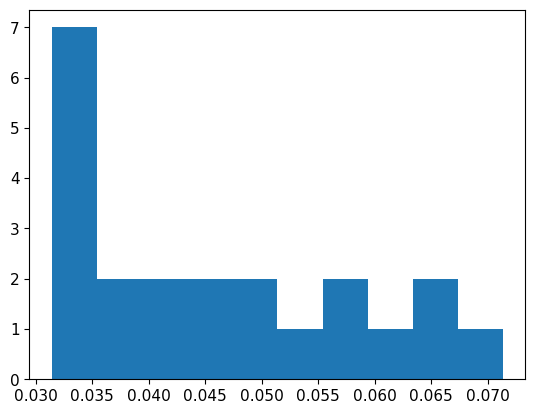

Median:  0.04393625259399414


In [15]:
plt.hist(prediction_times)
plt.show()
print("Median: ", np.median(prediction_times))

# Calculate metrics

## Lucas metric

In [6]:
def lucas_weight_func(x):
    y = np.ones(len(x))
    y[x > 5] = np.sin(x[x > 5] / 5 + 0.8) / 2 + 1 / 2  # np.exp(- x[x > 5] / 10 + 1/2)
    y[x > 20] = 0.01
    # y = np.tanh(-(x-12)/5)/2 + 1/2
    y *= 1000 / np.sum(y)

    return y


x = np.random.choice(np.logspace(0, 1.5, 100), 15)
x = np.sort(x)
y = lucas_weight_func(x)

print(lucas_weight_func(np.array([3, 6, 20])))

plt.scatter(x, y)

[511.099 487.92    0.98 ]


In [7]:
thresholds = [0.1, 0.5, 1, 3]
for threshold in thresholds:
    l_score, c_score, m_score, pos_2d_score, pos_3d_score = [], [], [], [], []

    print(f"Lucas score for T={threshold}")
    for i in range(len(global_predictions)):
        pred_to_gt, gt_fn = cd_metrics.match_cones(global_gt[i], global_predictions[i], threshold)

        l_score.append(
            cd_metrics.lucas_score(
                global_gt[i], global_predictions[i], pred_to_gt, gt_fn, threshold
            )
        )
        c_score.append(
            cd_metrics.colour_score(global_gt[i], global_predictions[i], pred_to_gt, gt_fn)
        )
        m_score.append(
            cd_metrics.matching_score(global_gt[i], global_predictions[i], pred_to_gt, gt_fn)
        )

        score_2d, score_3d = cd_metrics.pos_score(
            global_gt[i], global_predictions[i], pred_to_gt, gt_fn
        )
        pos_2d_score.append(score_2d)
        pos_3d_score.append(score_3d)

    df = pd.DataFrame(
        {
            "lucas": l_score,
            "colour": c_score,
            "matching": m_score,
            "2d": pos_2d_score,
            "3d": pos_3d_score,
        }
    )

    print(df.median())
    fig, ax = plt.subplots(ncols=5, figsize=(16, 2))
    df["lucas"].plot.hist(ax=ax[0])
    df["colour"].plot.hist(ax=ax[1])
    df["matching"].plot.hist(ax=ax[2])
    df["2d"].plot.hist(ax=ax[3])
    df["3d"].plot.hist(ax=ax[4])
    plt.show()

Lucas score for T=0.1
lucas      -546.430045
colour        1.000000
matching      0.062852
2d            0.028344
3d            0.273414
dtype: float64
Lucas score for T=0.5
lucas       809.586719
colour        1.000000
matching      0.595960
2d            0.203374
3d            0.367493
dtype: float64
Lucas score for T=1
lucas       935.803591
colour        1.000000
matching      0.708333
2d            0.240329
3d            0.408442
dtype: float64
Lucas score for T=3
lucas       978.601197
colour        1.000000
matching      0.750000
2d            0.308912
3d            0.445054
dtype: float64


In [8]:
np.median(prediction_times)

0.037279486656188965